### Demo notebook

Before using this notebook, you must create at least one dataset of your own and store the images in a dedicated folder. Images  can have any size. You also need to download the weights of a pre-trained FCN model, or train your own using either the `fcn_training.ipynb` notebook, or by executing `fcn_run_loop.py` from the command line.

In [1]:
import os.path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import backend as K
from distutils.version import LooseVersion

from kitty_road_dataset import KittyRoadDataset
from cam_vid_dataset import CamVidDataset
from pascal_voc_dataset import PascalVOC2012Dataset
from pascal_plus_dataset import PascalPlusDataset
from fcn_model import Model
from fcn_run_loop import clear_session
import image_utils as utils


%matplotlib inline
# This model has been tested with TF1.12. Using at least version 1.8 is only a suggestion.
assert LooseVersion(tf.__version__) >= LooseVersion('1.8'), 'Please use TensorFlow version 1.8 or newer. You are using {}'.format(tf.__version__)
print('TensorFlow version {}'.format(tf.__version__))
print('Keras version      {}'.format(tf.keras.__version__))
assert K.image_data_format() == 'channels_last'
assert K.floatx() == 'float32'

C:\Users\Florent\Anaconda3\envs\tfgpu\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version 1.12.0
Keras version      2.1.6-tf


Are you interested in a black theme for Jupyter notebooks? If yes, then copy the `dark_theme.css` to your .jupyter configuration directory and replace the path(s) below with your own location(s). Otherwise just remove this cell.

In [2]:
# Load a custom CSS for this notebook
from IPython.display import HTML

# Add a css file location for each of your working platforms
css_filenames = ['c:/users/asus-ux510/.jupyter/dark_theme.css', 
                 'c:/users/florent/.jupyter/dark_theme.css', 
                 'd:/userfiles/fmahoudeau/documents/.jupyter/dark_theme.css',
                 '/home/flo/.jupyter/dark_theme.css']

css = None
for css_filename in css_filenames:
    if os.path.isfile(css_filename):
        css = '<style>{}</style>'.format(open(css_filename).read())

HTML(css)

### Configuration

Set the `DATA_ROOT_PATH`, define the `SAVED_VARIABLES_PATH` of the model weights to restore, and specify the `DATASET_PATH` where the images to predict are located.

In [3]:
# Specify the root directory where all your datasets are located
if os.path.isdir('C:/Users/fmahoudeau/'):
    DATA_ROOT_PATH = 'C:/Users/fmahoudeau/Datasets/'
elif os.path.isdir('C:/Users/Florent/'):
    DATA_ROOT_PATH = 'G:/Datasets/'
else:
    assert False, 'Cannot resolve data root directory'

# Select the name of the model to load
# That name is simply the name of the dataset used to train that model
SAVED_VARIABLES = 'pascal_plus'
assert SAVED_VARIABLES in ('kitty_road', 'cam_vid', 'pascal_voc_2012', 'pascal_plus'), 'Unknown model name'

# Indicate the path to the saved variables and the model name (FCN32, FCN16 or FCN8)
SAVED_VARIABLES_PATH = os.path.join(DATA_ROOT_PATH, 'trained_models/tensorflow/')
if SAVED_VARIABLES == 'kitty_road':
    SAVED_VARIABLES_PATH = os.path.join(SAVED_VARIABLES_PATH, 'kitty_road/fcn8_trial_1-80')
    MODEL_NAME = 'FCN8'
    CMAP = KittyRoadDataset(augmentation_params=None).cmap
elif SAVED_VARIABLES == 'cam_vid':
    SAVED_VARIABLES_PATH = os.path.join(SAVED_VARIABLES_PATH, 'cam_vid/fcn8_trial_1-120')
    MODEL_NAME = 'FCN8'
    CMAP = CamVidDataset(augmentation_params=None).cmap
elif SAVED_VARIABLES == 'pascal_voc_2012':
    SAVED_VARIABLES_PATH = os.path.join(SAVED_VARIABLES_PATH, 'pasacl_voc_2012/fcn8_trial_2-75')
    MODEL_NAME = 'FCN8'
    CMAP = PascalVOC2012Dataset(augmentation_params=None).cmap
elif SAVED_VARIABLES == 'pascal_plus':
    SAVED_VARIABLES_PATH = os.path.join(SAVED_VARIABLES_PATH, 'pascal_plus/fcn8_trial_3-60')
    MODEL_NAME = 'FCN8'
    CMAP = PascalPlusDataset(augmentation_params=None).cmap

# Indicate the name of your custom dataset
# That name must be a folder containing the images to predict
# The images must be readable by OpenCV
DATASET_NAME = 'my_pascal'
assert DATASET_NAME in ('my_pascal', 'my_road'), 'Unknown dataset'

# For example, my first custom dataset is a set of pictures with objects 
# recognizable by a model trained on any PASCAL VOC dataset
if DATASET_NAME == 'my_pascal':
    DATASET_PATH = os.path.join(DATA_ROOT_PATH, 'my_pascal/')
    IMAGE_SHAPE = (512, 512)
    N_CLASSES = 21
    BATCH_SIZE = 8
# My second custom dataset is a set of road pictures
# It can potentially be predicted using a model trained with either the KittyRoad or CamVid dataset
elif DATASET_NAME == 'my_road':
    DATASET_PATH = os.path.join(DATA_ROOT_PATH, 'my_road/')
    IMAGE_SHAPE = (192, 640)
    N_CLASSES = 2
    BATCH_SIZE = 8

# This parameter is required to instantiate the FCN model class
VGG16_WEIGHTS_PATH = os.path.join(DATA_ROOT_PATH, 'vgg16/vgg16_weights.npz')

# The prediction masks will be saved in a sub-folder of your custom dataset folder
PREDICTIONS_PATH = os.path.join(DATASET_PATH, 'predictions/')
if not os.path.exists(PREDICTIONS_PATH):
    os.makedirs(PREDICTIONS_PATH)

DEBUG = True

### Predicting images from custom datasets

In [4]:
def load_dataset():
    """
    Loads all images located in the dataset path, resizing them to the target shape, 
    and padding with zeros as necessary. The aspect ratio is preserved.
    """
    X, X_shapes = [], []
    for filename in utils.listfiles(DATASET_PATH):
        im = utils.imread(os.path.join(DATASET_PATH, filename))
        height, width = im.shape[:2]

        # The image is smaller than the model input shape
        if (height <= IMAGE_SHAPE[0]) & (width <= IMAGE_SHAPE[1]):
            im = utils.pad(im, IMAGE_SHAPE, center=True, cval=0)  # Pad as necessary

        else:
            # Determine the resized shape, maintaining the aspect ratio
            if height > IMAGE_SHAPE[0]:
                ratio = IMAGE_SHAPE[0] / height
                height *= ratio
                width *= ratio
            if width > IMAGE_SHAPE[1]:
                ratio = IMAGE_SHAPE[1] / width
                height *= ratio
                width *= ratio
            height = min(round(height), IMAGE_SHAPE[0])
            width = min(round(width), IMAGE_SHAPE[1])
            # Resize and pad as necessary
            im = cv2.resize(im, (width, height), interpolation=cv2.INTER_AREA)
            im = utils.pad(im, IMAGE_SHAPE, center=True, cval=0)
        X.append(im)
        X_shapes.append((height, width))
    X = np.asarray(X)
    X_shapes = np.asarray(X_shapes)
    
    if DEBUG:
        print(X.shape, X_shapes.shape)
    
    # Build a TF dataset and return the next sample
    dataset = tf.data.Dataset.from_tensor_slices((X, X_shapes))
    dataset = dataset.batch(BATCH_SIZE)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [5]:
def load_model():
    """
    Creates the FCN model and restores its pre-trained weights.
    If a session already exists, it is first closed and the resources 
    are released before opening a new session.
    """
    sess = clear_session()
    model = Model(IMAGE_SHAPE, N_CLASSES, VGG16_WEIGHTS_PATH)
    model(MODEL_NAME)
    model.load_variables(SAVED_VARIABLES_PATH)
    model.logits = tf.reshape(model.outputs, (-1, N_CLASSES+1), name="logits")
    return model, sess

In [6]:
def predict_dataset(sess, next_sample):
    """
    Predict the pixel-level semantic class of each image,
    and saves the masked images to disk.
    """
    y_pred = []
    idx = 0  # The image name is it's index in the list
    while True:
        try:
            im_batch, shape_batch = sess.run(next_sample)

            # Returns a 1-item list containing a numpy vector of length BATCH_SIZE * N_PIXELS * N_CLASSES
            im_softmax = sess.run([tf.nn.softmax(model.logits)], {model.keep_prob: 1.0,
                                                                  model.inputs: im_batch})[0]
            im_softmax = im_softmax.reshape((len(im_batch), np.prod(model.image_shape), N_CLASSES+1))

            for i in range(len(im_batch)):
                # Predict pixel class and expand with a channel dimension.
                im_pred = np.argmax(im_softmax[i], axis=1).reshape(model.image_shape)
                im_pred = utils.labels2colors(im_pred, CMAP)
                im_masked = utils.center_crop(utils.apply_mask(im_batch[i], im_pred), shape_batch[i][:2])
                utils.imwrite(os.path.join(PREDICTIONS_PATH, str(idx) + '.jpg'), im_masked)
                y_pred.append(im_masked)
                idx += 1
        except tf.errors.OutOfRangeError:
            break
    return y_pred

In [7]:
def dual_plot(im1, im2):
    """Utility function to display 2 images side by side."""
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.imshow(im1)
    plt.subplot(122)
    plt.imshow(im2)
    plt.show()

### Custom dataset 1

The first experiment deals with a FCN8 model pre-trained on PASCAL Plus.

In [8]:
# Load images, create a TF session, and restore the FCN model for inference
model, sess = load_model()
next_sample = load_dataset()
y_pred = predict_dataset(sess, next_sample)

Building FCN8 for end-to-end training...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/pascal_plus/fcn8_trial_3-60
(24, 512, 512, 3) (24, 2)


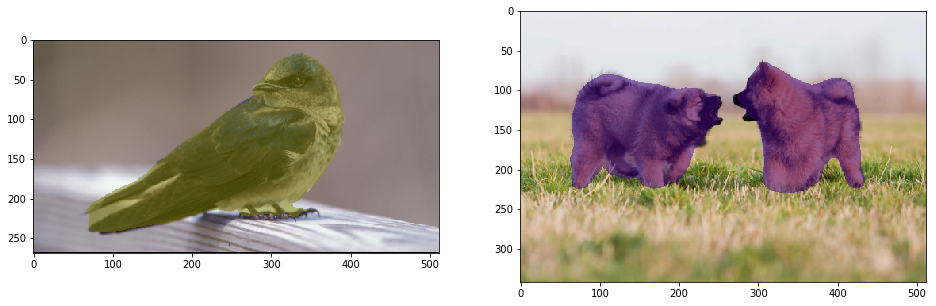

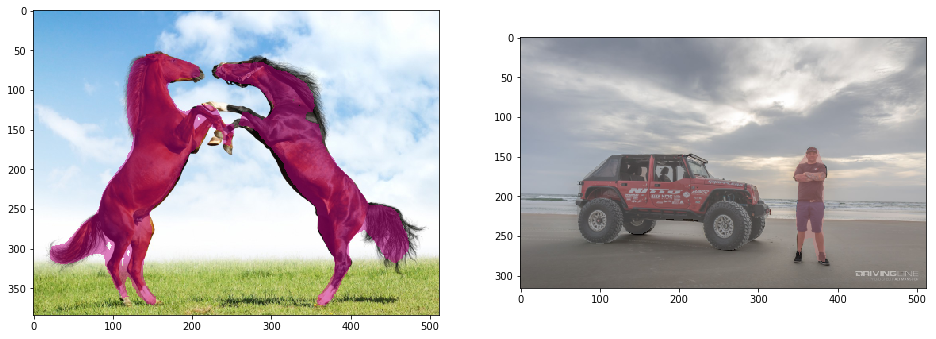

In [9]:
dual_plot(y_pred[2], y_pred[10])
dual_plot(y_pred[13], y_pred[14])

### Custom dataset 2

The second experiment deals with a FCN8 model pre-trained on Kitty Road.

In [10]:
SAVED_VARIABLES_PATH = os.path.join(DATA_ROOT_PATH, 'trained_models/tensorflow/kitty_road/fcn8_trial_1-80')
MODEL_NAME = 'FCN8'
CMAP = KittyRoadDataset(augmentation_params=None).cmap
DATASET_PATH = os.path.join(DATA_ROOT_PATH, 'my_road/')
IMAGE_SHAPE = (192, 640)
N_CLASSES = 2
BATCH_SIZE = 8
PREDICTIONS_PATH = os.path.join(DATASET_PATH, 'predictions/')
if not os.path.exists(PREDICTIONS_PATH):
    os.makedirs(PREDICTIONS_PATH)

In [11]:
# Load images, create a TF session, and restore the FCN model for inference
model, sess = load_model()
next_sample = load_dataset()
y_pred = predict_dataset(sess, next_sample)

Building FCN8 for end-to-end training...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/kitty_road/fcn8_trial_1-80
(11, 192, 640, 3) (11, 2)


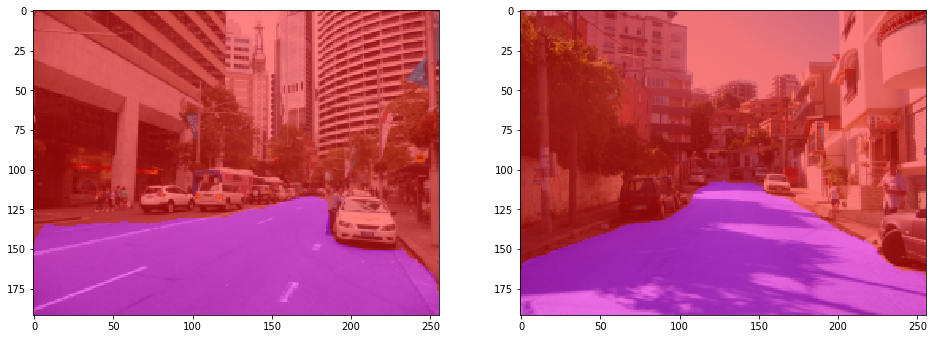

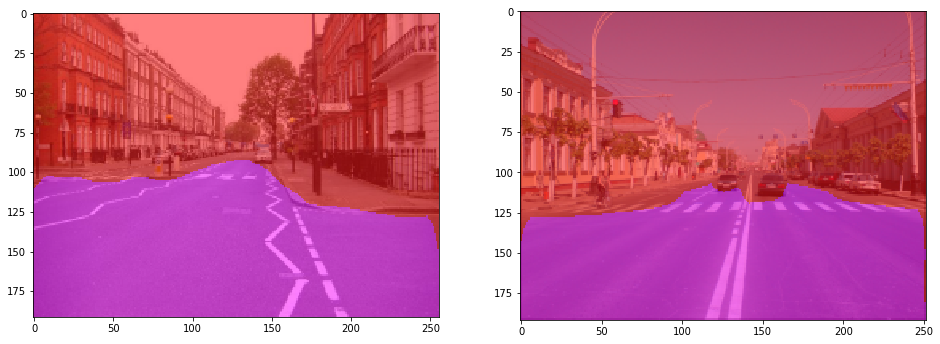

In [12]:
dual_plot(y_pred[0], y_pred[5])
dual_plot(y_pred[7], y_pred[10])